# Soybean Disease Domain Generalization PoC
## Baseline: USA (ASDID) to India (MH-SoyaHealthVision)

This notebook evaluates the generalization performance of deep learning models across geographically distinct datasets.

### Models Supported:
- **ConvNeXt-Tiny**: Modern architecture, uses Layer Normalization (AdaBN is a no-op).
- **ResNet-50**: Classic architecture, uses **Batch Normalization** (Required for AdaBN verification).

### Features:
- **Quick Check Mode**: Run a fast verification with 1 epoch and 1 seed.
- **Training Logs**: Epoch-wise Loss and Val F1 are saved to `results/training_logs`.
- **Split Recording**: Tracks exactly which images were used in each split.
- **Sample Inspection**: Visualizes correct and incorrect predictions for ASDID, Direct Transfer, and AdaBN.
- **Error Analysis**: Specific visualization for Frogeye vs. Rust misclassifications.

In [6]:
%load_ext autoreload
%autoreload 2

import torch
import os
import sys
from tqdm.notebook import tqdm

# Add src to path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from src.dataset import get_dataloaders
from src.model import get_model, apply_adabn
from src.utils import (
    set_seed, 
    calculate_metrics, 
    log_experiment, 
    log_training_progress,
    save_splits, 
    plot_confusion_matrix, 
    plot_loss_curves, 
    inspect_samples,
    get_specific_errors,
    plot_specific_errors
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Configuration

In [7]:
# MODEL_NAME options: "convnext_tiny", "resnet50"
MODEL_NAME = "resnet50"  # Use resnet50 to see AdaBN effects!

QUICK_CHECK = True  # Set to False for full experiment [21, 42, 73]
EPOCHS = 1 if QUICK_CHECK else 5
SEEDS = [42] if QUICK_CHECK else [21, 42, 73]

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
DATA_ASDID = "../data/ASDID"
DATA_MH = "../data/MH-SoyaHealthVision/Soyabean_Leaf_Image_Dataset"
CLASS_NAMES = ['Healthy', 'Rust', 'Frogeye']

print(f"Using model: {MODEL_NAME}")
print(f"Using device: {DEVICE}")
print(f"Mode: {'Quick Check' if QUICK_CHECK else 'Full Run'}")

Using model: resnet50
Using device: mps
Mode: Quick Check


## Training & Evaluation Logic

In [8]:
def train_model(model, train_loader, val_loader, device, run_id, epochs=5, lr=1e-4):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    train_losses = []
    val_f1s = []
    best_val_f1 = 0
    best_model_state = None
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
        for inputs, labels in pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            pbar.set_postfix({'loss': loss.item()})
            
        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        
        # Validation
        val_metrics = evaluate_model(model, val_loader, device)
        val_f1s.append(val_metrics['F1'])
        print(f"Epoch {epoch+1} - Loss: {epoch_loss:.4f}, Val F1: {val_metrics['F1']:.4f}")
        
        # Log Progress
        log_training_progress(run_id, epoch + 1, epoch_loss, val_metrics['F1'], log_dir="../results/training_logs")
        
        if val_metrics['F1'] > best_val_f1:
            best_val_f1 = val_metrics['F1']
            best_model_state = model.state_dict().copy()
            
    model.load_state_dict(best_model_state)
    return model, train_losses, val_f1s

def evaluate_model(model, test_loader, device, verbose=False):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    metrics = calculate_metrics(all_labels, all_preds)
    if verbose:
        print(f"Accuracy: {metrics['Accuracy']:.4f}")
        print(f"F1 Score (Macro): {metrics['F1']:.4f}")
        print(f"Precision (Macro): {metrics['Precision']:.4f}")
        print(f"Recall (Macro): {metrics['Recall']:.4f}")
    return metrics

## Experiment Pipeline


Starting Experiment: resnet50_Seed_42
Random seed set to: 42
Loaded 4799 samples for ASDID dataset.
Loaded 1225 samples for MH dataset.
Splits saved to ../results/splits/ASDID_resnet50_seed42_splits.txt
Splits saved to ../results/splits/MH_resnet50_seed42_splits.txt
Model 'resnet50' loaded and adapted for 3 classes.


Epoch 1/1:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 1 - Loss: 0.3937, Val F1: 0.9703


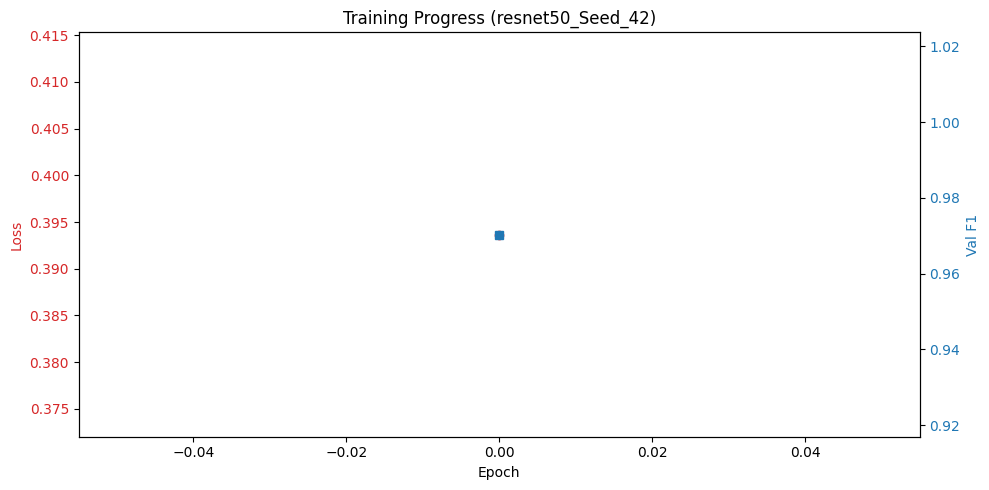


Evaluating on ASDID Test Set (Sanity Check)...
Accuracy: 0.9681
F1 Score (Macro): 0.9668
Precision (Macro): 0.9690
Recall (Macro): 0.9657


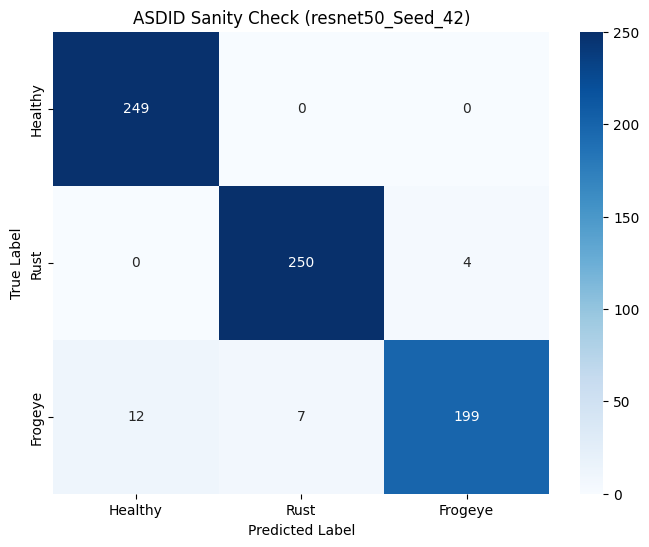


Inspecting ASDID Samples...


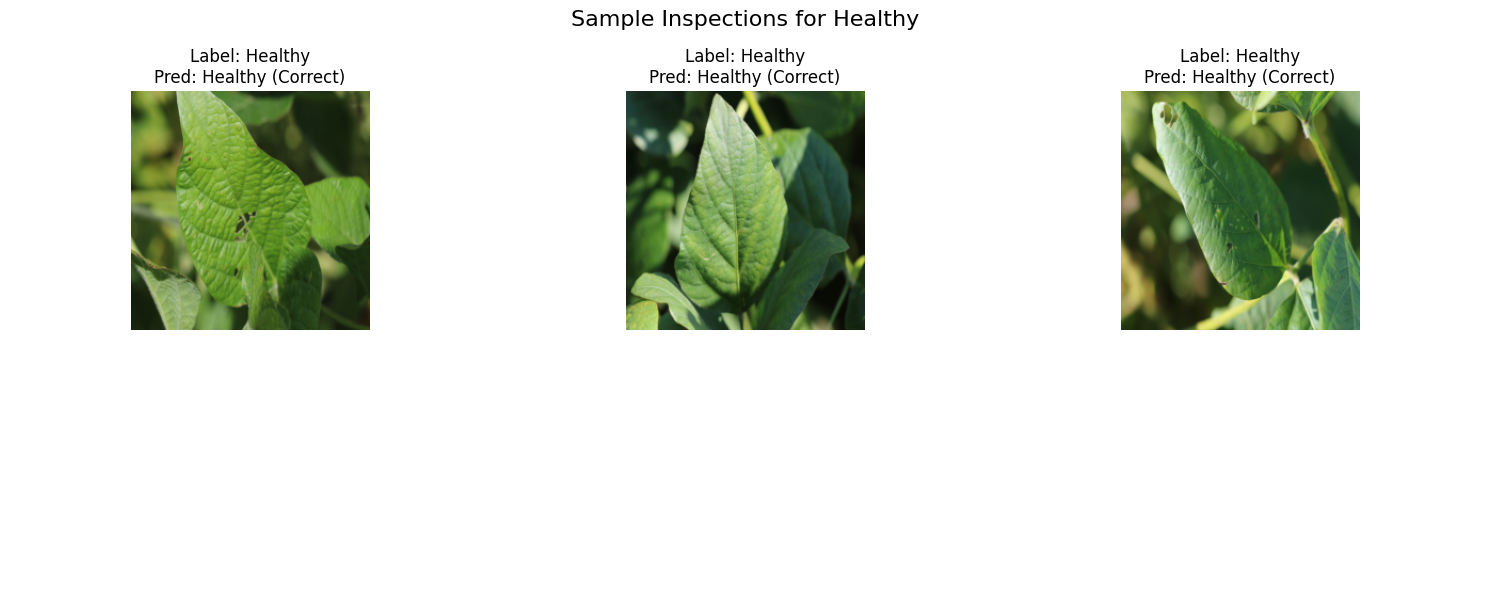

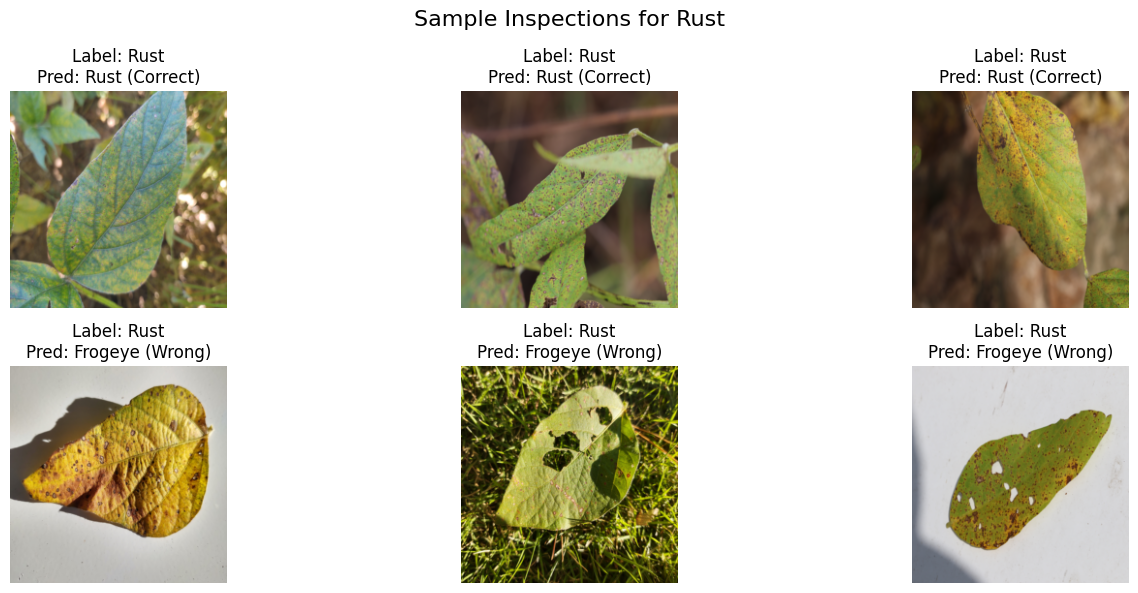

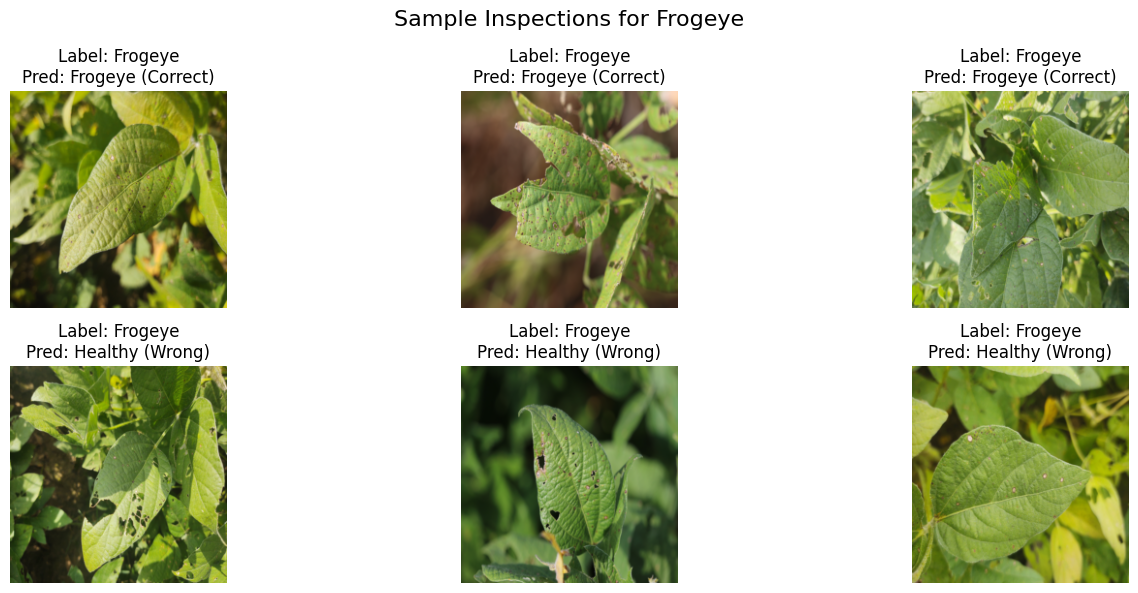


Evaluating Direct Transfer to MH...
Accuracy: 0.8595
F1 Score (Macro): 0.7106
Precision (Macro): 0.7271
Recall (Macro): 0.7078


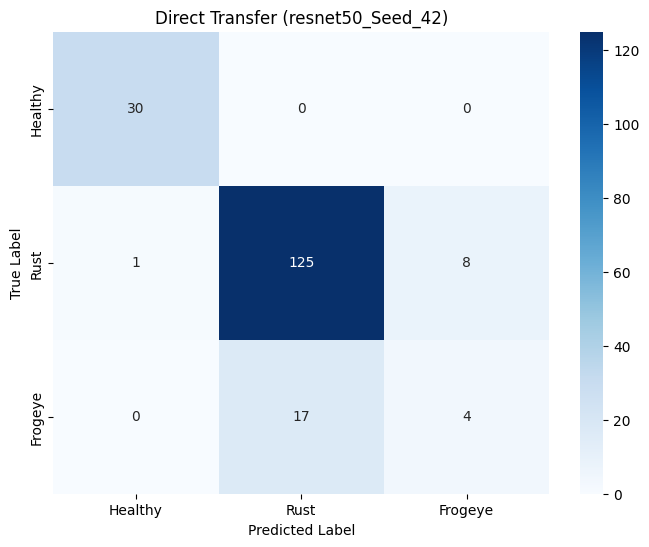

Experiment logged to ../results/experiment_logs/experiment_registry.csv

Inspecting Direct Transfer Samples...


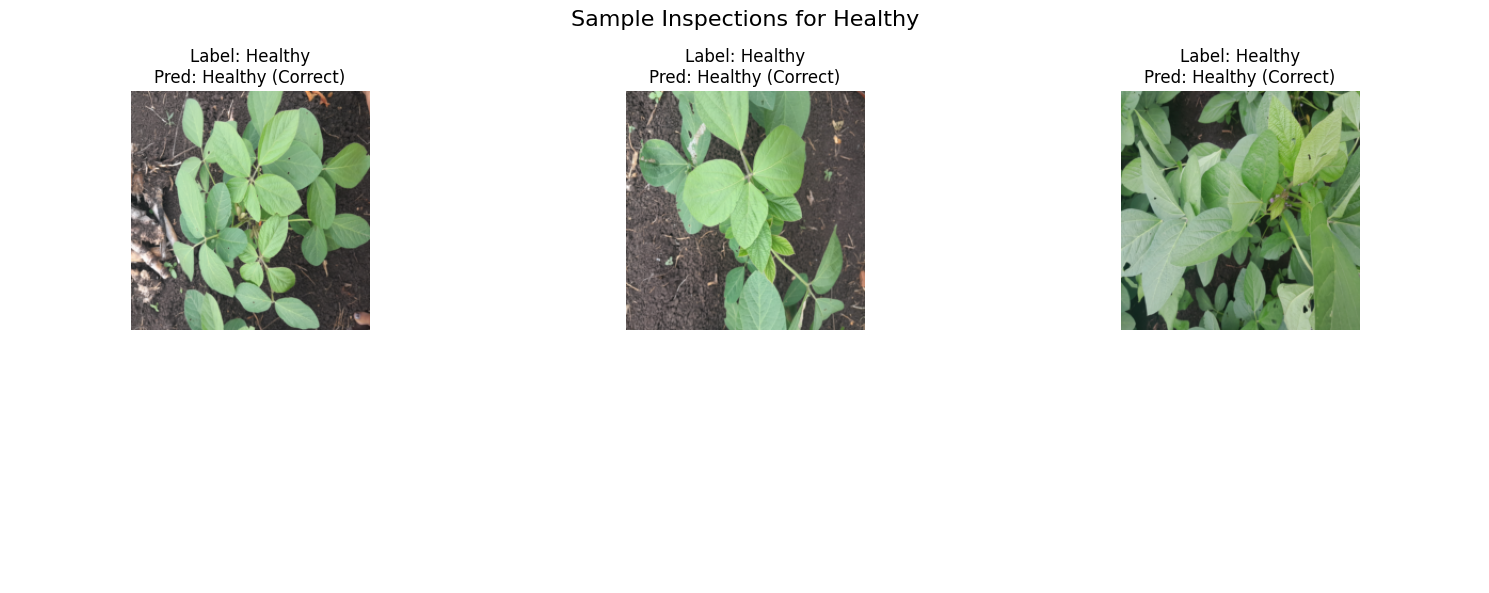

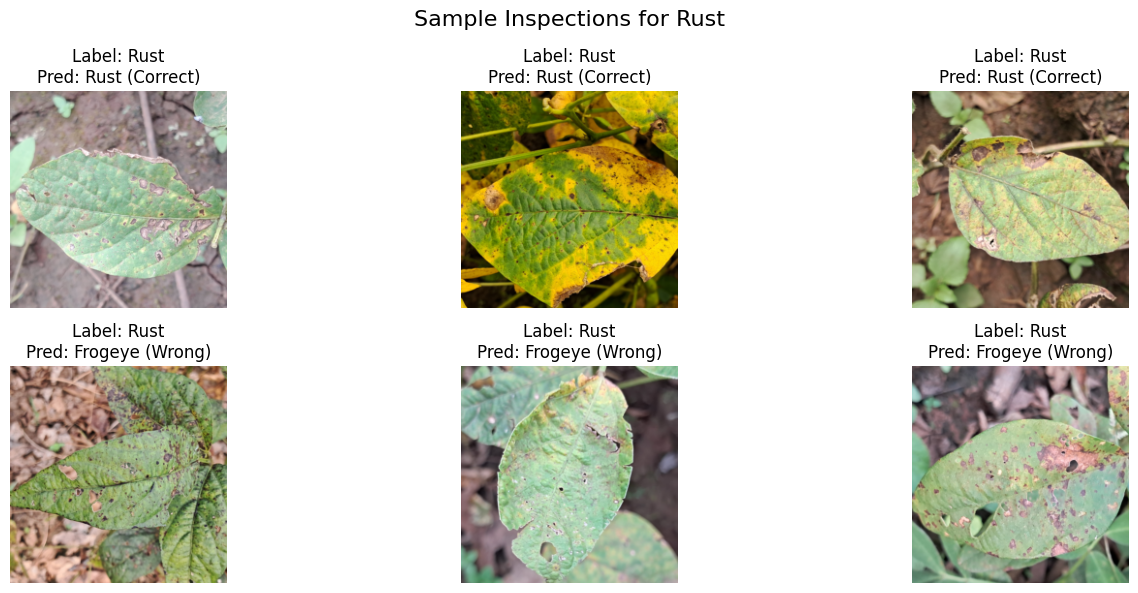

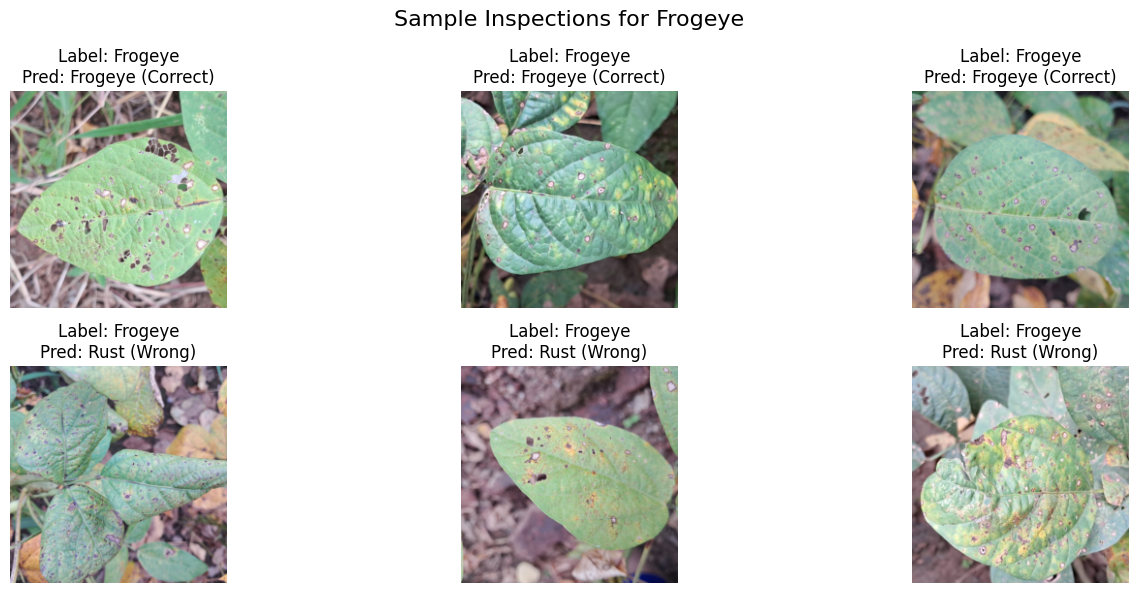


Applying AdaBN adaptation...
Model 'resnet50' loaded and adapted for 3 classes.
AdaBN: Domain adaptation via BN statistics update completed.

Evaluating AdaBN on MH...
Accuracy: 0.6054
F1 Score (Macro): 0.5585
Precision (Macro): 0.5527
Recall (Macro): 0.6712


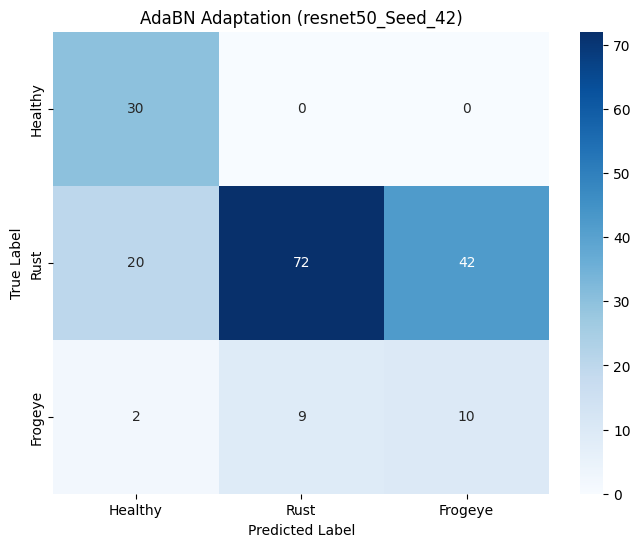

Experiment logged to ../results/experiment_logs/experiment_registry.csv

Inspecting AdaBN Adaptation Samples...


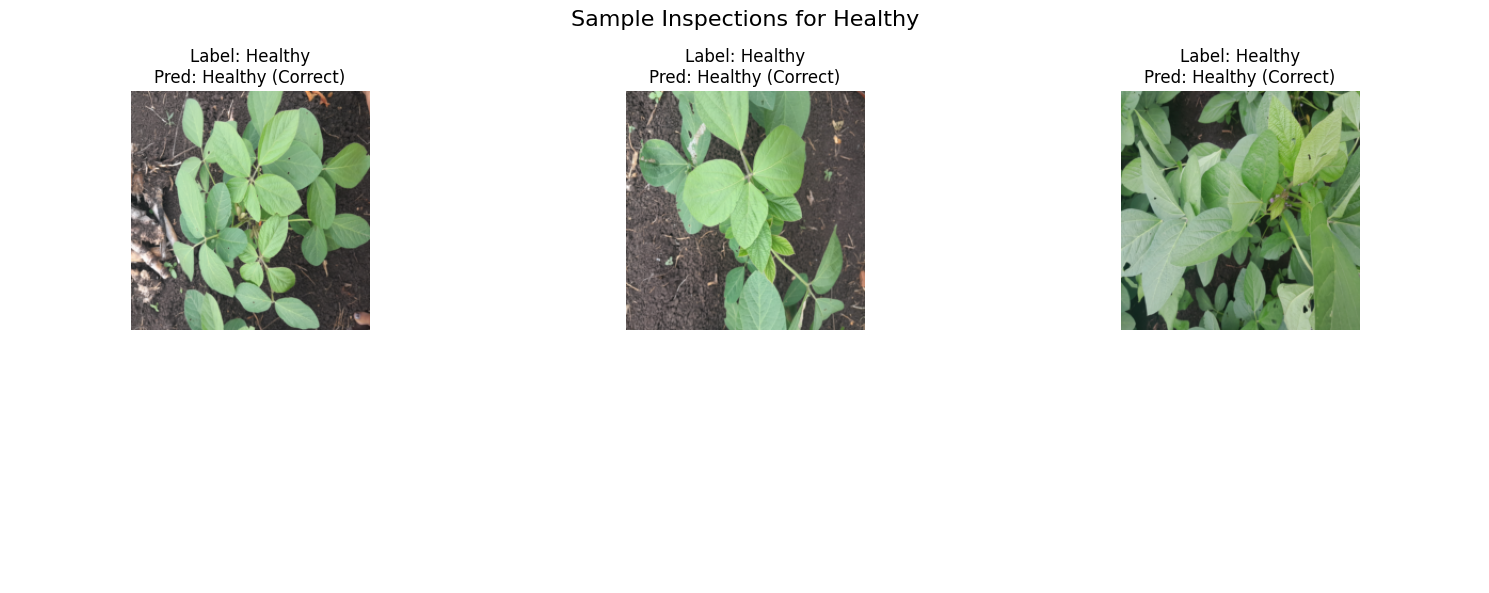

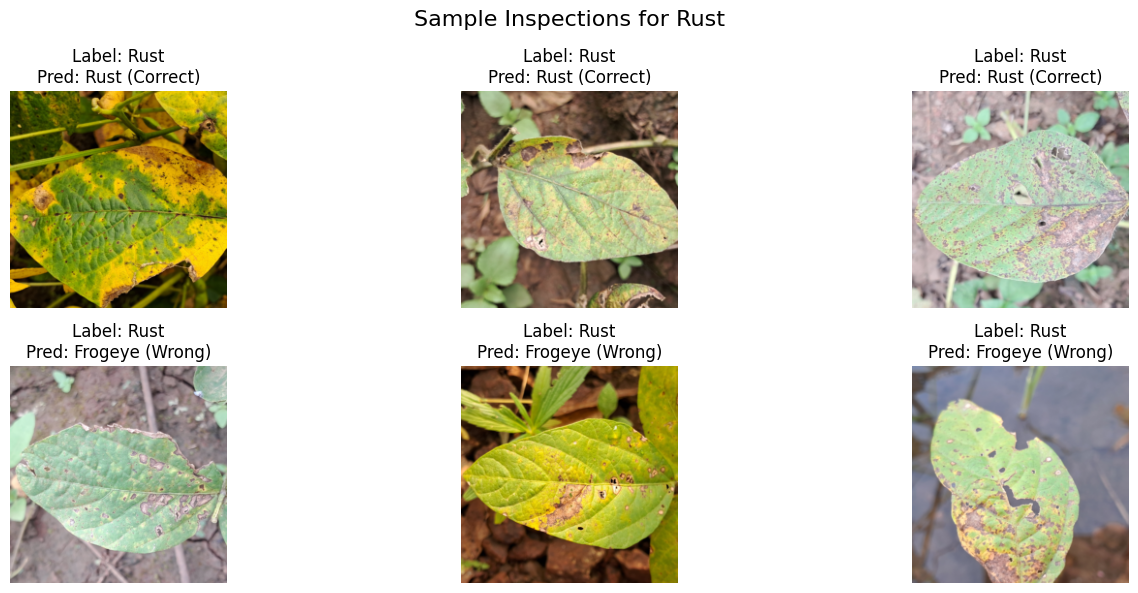

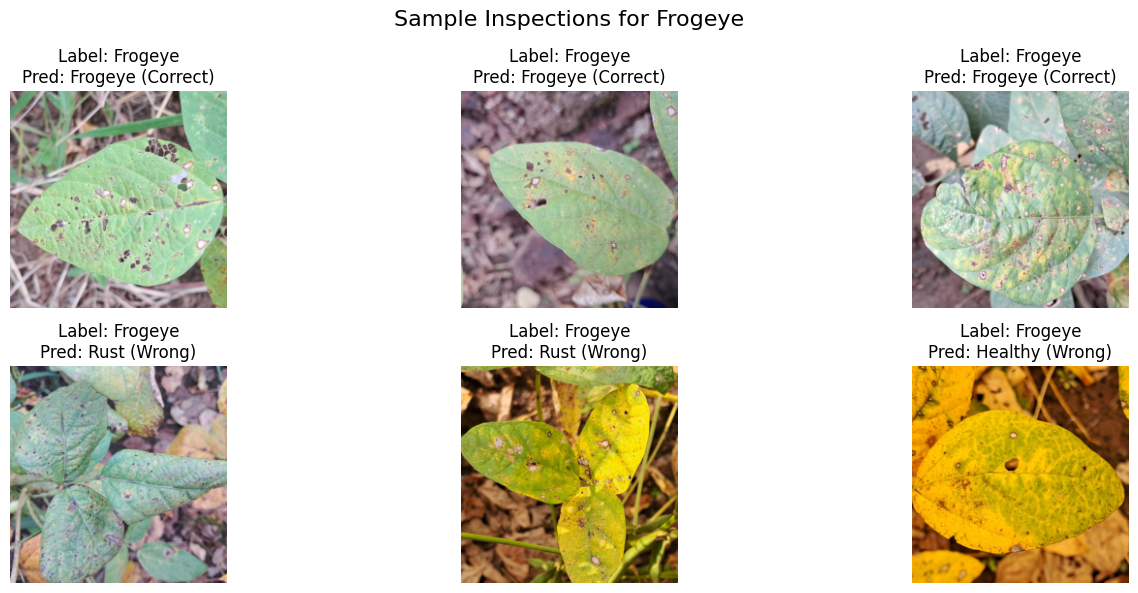

In [9]:
for seed in SEEDS:
    run_id = f"{MODEL_NAME}_Seed_{seed}"
    print(f"\n{'='*20}\nStarting Experiment: {run_id}\n{'='*20}")
    set_seed(seed)
    
    # 1. Setup Data
    train_loader_asdid, val_loader_asdid, test_loader_asdid, ds_asdid, tr_idx_asdid, val_idx_asdid, ts_idx_asdid = get_dataloaders("ASDID", DATA_ASDID, seed=seed)
    train_loader_mh, _, test_loader_mh, ds_mh, _, _, ts_idx_mh = get_dataloaders("MH", DATA_MH, seed=seed)
    
    # Save Splits
    save_splits(ds_asdid, tr_idx_asdid, val_idx_asdid, ts_idx_asdid, seed, f"ASDID_{MODEL_NAME}", log_dir="../results/splits")
    save_splits(ds_mh, None, None, ts_idx_mh, seed, f"MH_{MODEL_NAME}", log_dir="../results/splits")
    
    # 2. Baseline Training on ASDID
    model = get_model(MODEL_NAME, num_classes=3).to(DEVICE)
    model, train_losses, val_f1s = train_model(model, train_loader_asdid, val_loader_asdid, DEVICE, run_id, epochs=EPOCHS)
    
    plot_loss_curves(train_losses, val_f1s, title=f'Training Progress ({run_id})')
    
    # 3. Evaluation on ASDID Test Set (Sanity Check)
    print("\nEvaluating on ASDID Test Set (Sanity Check)...")
    metrics_asdid = evaluate_model(model, test_loader_asdid, DEVICE, verbose=True)
    plot_confusion_matrix(metrics_asdid['Confusion_Matrix'], CLASS_NAMES, title=f'ASDID Sanity Check ({run_id})')
    
    # Inspect ASDID Samples
    print("\nInspecting ASDID Samples...")
    inspect_samples(model, test_loader_asdid, DEVICE, CLASS_NAMES)
    
    # 4. Evaluation A – Direct Transfer to MH
    print("\nEvaluating Direct Transfer to MH...")
    metrics_direct = evaluate_model(model, test_loader_mh, DEVICE, verbose=True)
    plot_confusion_matrix(metrics_direct['Confusion_Matrix'], CLASS_NAMES, title=f'Direct Transfer ({run_id})')
    log_experiment(f"Run_{seed}_Baseline", seed, MODEL_NAME, "ASDID", "MH", metrics_direct, adaptation="None", log_dir="../results/experiment_logs")
    
    # Inspect Direct Transfer Samples
    print("\nInspecting Direct Transfer Samples...")
    inspect_samples(model, test_loader_mh, DEVICE, CLASS_NAMES)
    
    # 5. Evaluation B – Adaptation (AdaBN)
    print("\nApplying AdaBN adaptation...")
    model_adabn = get_model(MODEL_NAME, num_classes=3).to(DEVICE)
    model_adabn.load_state_dict(model.state_dict())
    
    model_adabn = apply_adabn(model_adabn, train_loader_mh, DEVICE)
    
    print("\nEvaluating AdaBN on MH...")
    metrics_adabn = evaluate_model(model_adabn, test_loader_mh, DEVICE, verbose=True)
    plot_confusion_matrix(metrics_adabn['Confusion_Matrix'], CLASS_NAMES, title=f'AdaBN Adaptation ({run_id})')
    log_experiment(f"Run_{seed}_AdaBN", seed, MODEL_NAME, "ASDID", "MH", metrics_adabn, adaptation="AdaBN", log_dir="../results/experiment_logs")
    
    # Inspect AdaBN Adaptation Samples
    print("\nInspecting AdaBN Adaptation Samples...")
    inspect_samples(model_adabn, test_loader_mh, DEVICE, CLASS_NAMES)

## Error Analysis: Frogeye vs. Rust

Investigating the top 5 high-confidence misclassifications where **Frogeye** was predicted as **Rust**.

Analysis for resnet50 - Seed 42


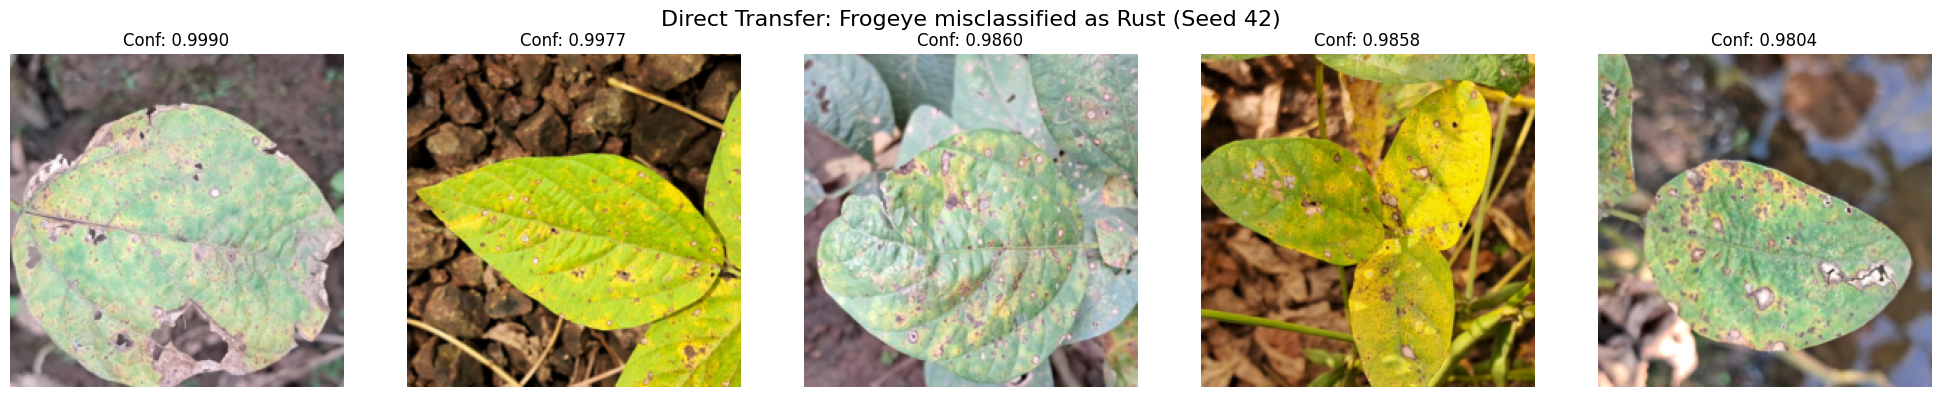

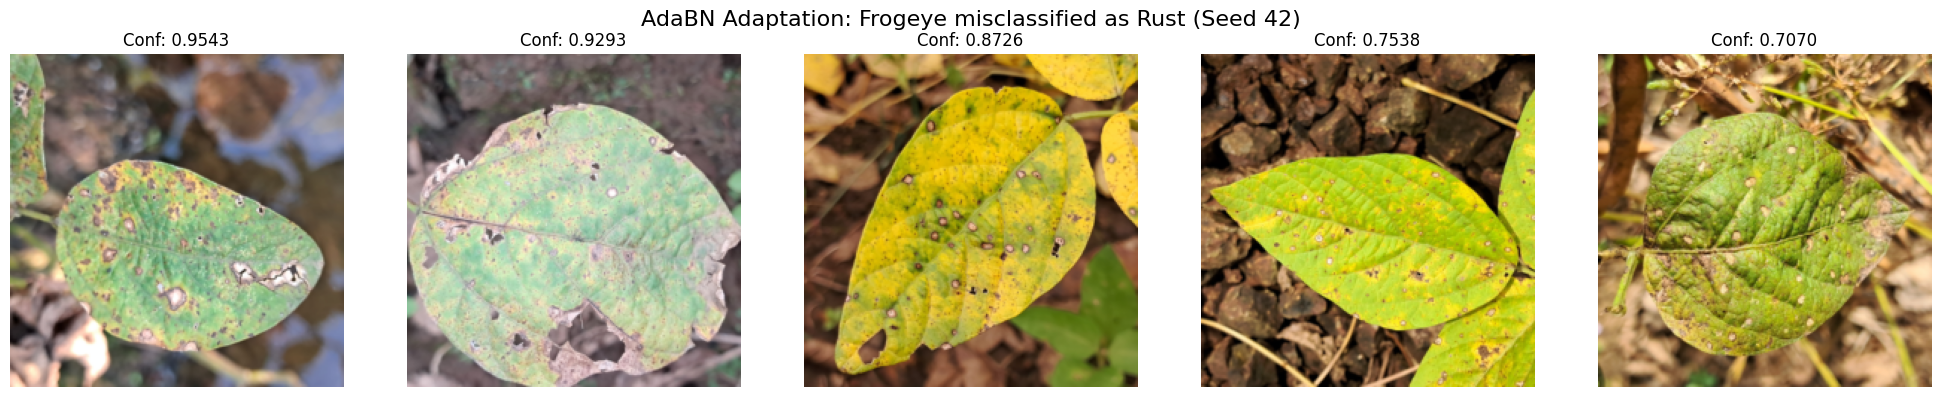

In [10]:
# Analysis for the LAST seed processed in the loop above
print(f"Analysis for {MODEL_NAME} - Seed {seed}")

# 1. Direct Transfer Errors
errors_direct = get_specific_errors(model, test_loader_mh, DEVICE, CLASS_NAMES, target_class="Frogeye", pred_class="Rust", top_n=5)
plot_specific_errors(errors_direct, title=f"Direct Transfer: Frogeye misclassified as Rust (Seed {seed})")

# 2. AdaBN Adaptation Errors
errors_adabn = get_specific_errors(model_adabn, test_loader_mh, DEVICE, CLASS_NAMES, target_class="Frogeye", pred_class="Rust", top_n=5)
plot_specific_errors(errors_adabn, title=f"AdaBN Adaptation: Frogeye misclassified as Rust (Seed {seed})")

In [14]:
# print training progress
import pandas as pd

logs = pd.read_csv("../results/training_logs/resnet50_Seed_42_progress.csv")
print(logs)

   Epoch  Train_Loss  Val_F1
0      1      0.3937  0.9703
